# Chest X-Ray Medical Diagnosis with Deep Learning

# Model Interpretation Methods

<img src="xray-header-image.png" style="padding-top: 50px;width: 87%;left: 0px;margin-left: 0px;margin-right: 0px;">

In [65]:
# Import necessary packages
import keras
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import cv2
import sklearn
import shap
import os
import seaborn as sns
import time
import pickle

sns.set()

# This sets a common size for all the figures we will draw.
plt.rcParams['figure.figsize'] = [10, 7]

# Data Exploration
we will work with chest x-ray images taken from the public [ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315). In this notebook, you'll get a chance to explore this dataset and familiarize yourself with .


In [3]:
# Read csv file containing training datadata
train_df = pd.read_csv("nih_new/train-small.csv")
valid_df = pd.read_csv("nih_new/valid-small.csv")
test_df = pd.read_csv("nih_new/test.csv")
print(f'There are {train_df.shape[0]} rows and {train_df.shape[1]} columns in the train data frame')
train_df.head()

There are 1000 rows and 16 columns in the train data frame


,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


In [4]:
print(f"Train set: The total patient ids are {train_df['PatientId'].count()}, from those the unique ids are {train_df['PatientId'].value_counts().shape[0]} ")
print(f"Validation set: The total patient ids are {valid_df['PatientId'].count()}")
print(f"Test set: The total patient ids are {test_df['PatientId'].count()}")

Train set: The total patient ids are 1000, from those the unique ids are 928 
Validation set: The total patient ids are 200
Test set: The total patient ids are 420


### Preventing Data Leakage
It is worth noting that our dataset contains multiple images for each patient. This could be the case, for example, when a patient has taken multiple X-ray images at different times during their hospital visits. In our data splitting, we have ensured that the split is done on the patient level so that there is no data "leakage" between the train, validation, and test datasets.

In [5]:
def check_for_leakage(df1, df2, patient_col):
    """
    Return True if there any patients are in both df1 and df2.

    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        patient_col (str): string name of column with patient IDs
    
    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    df1_patients_unique = set(df1[patient_col])
    df2_patients_unique = set(df2[patient_col])
    
    patients_in_both_groups = list(df1_patients_unique.intersection(df2_patients_unique))

    # leakage contains true if there is patient overlap, otherwise false.
    leakage = len(patients_in_both_groups) > 0 
    
    ### END CODE HERE ###
    
    return leakage

In [6]:
print("leakage between train and test: {}".format(check_for_leakage(train_df, test_df, 'PatientId')))
print("leakage between valid and test: {}".format(check_for_leakage(valid_df, test_df, 'PatientId')))

leakage between train and test: False
leakage between valid and test: False


### Explore data labels
Create a list of the names of each patient condition or disease. 

In [7]:
columns = train_df.keys()
columns = list(columns)
print(columns)

['Image', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'PatientId', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [8]:
# Remove unnecesary elements
columns.remove('Image')
columns.remove('PatientId')
# Get the total classes
print(f"There are {len(columns)} columns of labels for these conditions: {columns}")
# Print out the number of positive labels for each class
for column in columns:
    print(f"The class {column} has {train_df[column].sum()} samples")

There are 14 columns of labels for these conditions: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
The class Atelectasis has 106 samples
The class Cardiomegaly has 20 samples
The class Consolidation has 33 samples
The class Edema has 16 samples
The class Effusion has 128 samples
The class Emphysema has 13 samples
The class Fibrosis has 14 samples
The class Hernia has 2 samples
The class Infiltration has 175 samples
The class Mass has 45 samples
The class Nodule has 54 samples
The class Pleural_Thickening has 21 samples
The class Pneumonia has 10 samples
The class Pneumothorax has 38 samples


### Data Visualization
Using the image names listed in the csv file, retrieve the image associated with each row of data in your dataframe. 

Display Random Images


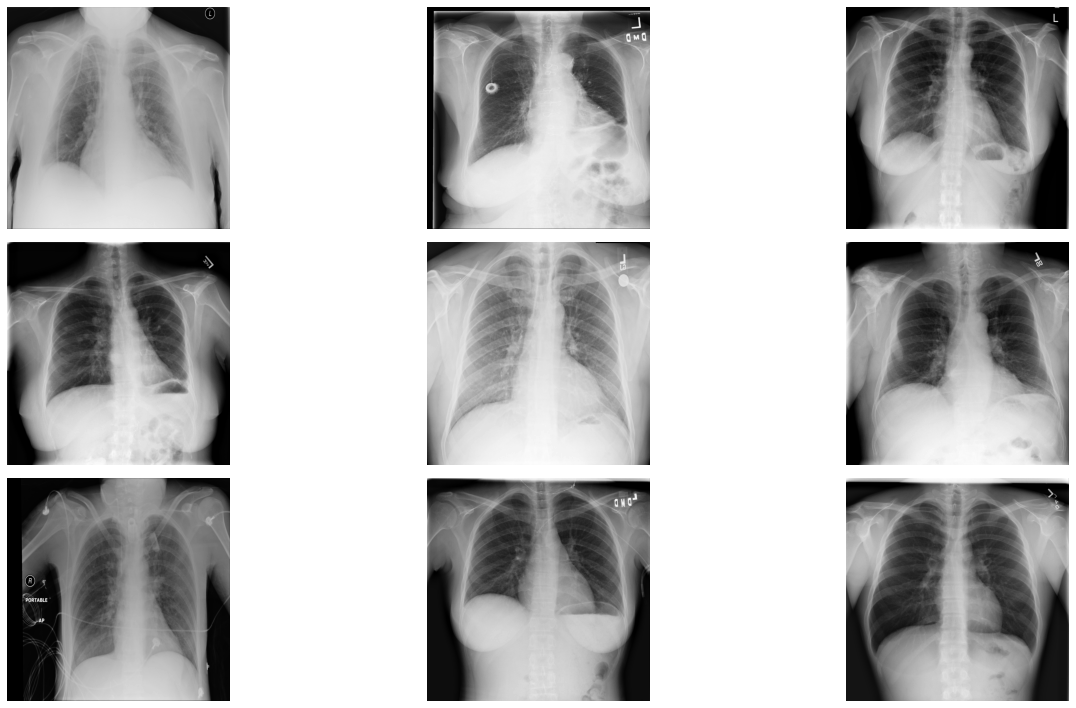

In [9]:
# Extract numpy values from Image column in data frame
images = train_df['Image'].values

# Extract 9 random images from it
random_images = [np.random.choice(images) for i in range(9)]

# Location of the image dir
img_dir = 'nih_new/images-small/'

print('Display Random Images')

# Adjust the size of your images
plt.figure(figsize=(20,10))

# Iterate and plot random images
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(img_dir, random_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()    

### Investigate a single image
Look at the first image in the dataset and print out some details of the image contents.

The dimensions of the image are 1024 pixels width and 1024 pixels height, one single color channel
The maximum pixel value is 0.9804 and the minimum is 0.0000
The mean value of the pixels is 0.4796 and the standard deviation is 0.2757


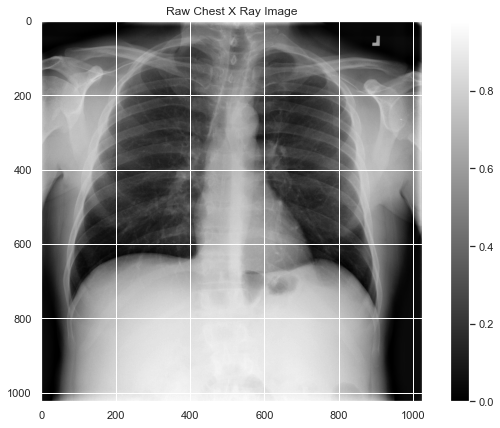

In [10]:
# Get the first image that was listed in the train_df dataframe
sample_img = train_df.Image[0]
raw_image = plt.imread(os.path.join(img_dir, sample_img))
plt.imshow(raw_image, cmap='gray')
plt.grid(color='w', linestyle='-', linewidth=1)
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {raw_image.shape[0]} pixels width and {raw_image.shape[1]} pixels height, one single color channel")
print(f"The maximum pixel value is {raw_image.max():.4f} and the minimum is {raw_image.min():.4f}")
print(f"The mean value of the pixels is {raw_image.mean():.4f} and the standard deviation is {raw_image.std():.4f}")

### Investigate pixel value distribution
Plot up the distribution of pixel values in the image shown above. 

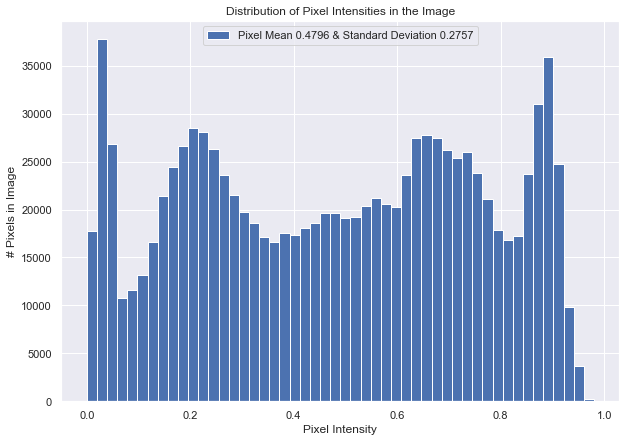

In [11]:
pixels = np.reshape(raw_image,raw_image.shape[0]*raw_image.shape[1])
plt.hist(pixels, bins=50, label=f'Pixel Mean {np.mean(raw_image):.4f} & Standard Deviation {np.std(raw_image):.4f}')
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')
plt.show()

# Image Preprocessing in Keras
### Standardization

Normalizing images is better suited for training a convolutional neural network. For this task we use the Keras [ImageDataGenerator](https://keras.io/preprocessing/image/) function to perform data preprocessing and data augmentation.
The `image_generator` will adjust the image data such that the new mean of the data will be zero, and the standard deviation of the data will be 1.  

In other words, the generator will replace each pixel value in the image with a new value calculated by subtracting the mean and dividing by the standard deviation.

$$\frac{x_i - \mu}{\sigma}$$

Create an image generator for preprocessing. Pre-process the data using the `image_generator`as well as reduce the image size down to 320x320 pixels.

In [12]:
# Import data generator from keras https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator

In [13]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """        
    print("getting train generator...") 
    # Normalize images  --- Generate batches of tensor image data with real-time data augmentation
    image_generator = ImageDataGenerator(
        samplewise_center=True,              #Set each sample mean to 0
        samplewise_std_normalization= True)  # Divide each input by its standard deviation
    
    # flow from directory with specified batch size and target image size
    # flow_from_dataframe ==> https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
    # RETURNS a DataFrameIterator yielding tuples of (x, y) where x is a numpy array containing a batch of images with 
    # shape (batch_size, *target_size, channels) and y is a numpy array of corresponding labels
    # default data format of ImageGenerator is channels_last
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",       #  Mode for yielding the targets, one of "binary", "categorical", "input", "multi_output", "raw", sparse" or None. Default: "categorical".
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

In [14]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, 
                                 seed=1, target_w = 320, target_h = 320):
    """
    Return generator for validation set and test test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    # get generator to sample dataset
    print(f"\nextracting {sample_size} train images to normalize validation and test datasets...")

    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col="Image", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next() # generate a batch of samples and associated labels 
    data_sample = batch[0]             # => we need only the sample imgs ie batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data - we use this generator normalizing mean and std using the train sample of 100
    image_generator.fit(data_sample)
    
    print("\ngetting valid generator...")

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    
    print("\ngetting test generator...")
    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [16]:
labels = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis',
              'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']
IMAGE_DIR = "nih_new/images-small/"
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)

getting train generator...
Found 1000 validated image filenames.

extracting 100 train images to normalize validation and test datasets...
Found 1000 validated image filenames.

getting valid generator...
Found 200 validated image filenames.

getting test generator...
Found 420 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The dimensions of the image are 320 pixels width and 320 pixels height
The maximum pixel value is 2.8194 and the minimum is -3.4863
The mean value of the pixels is 0.0000 and the standard deviation is 1.0000


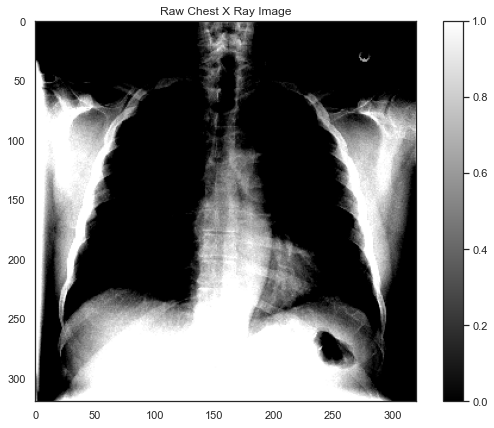

In [17]:
# Plot a processed image
sns.set_style("white")
generated_image, label = train_generator.__getitem__(0)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

In [18]:
print(generated_image.shape, generated_image[0].shape)
print(raw_image.shape)

(8, 320, 320, 3) (320, 320, 3)
(1024, 1024)


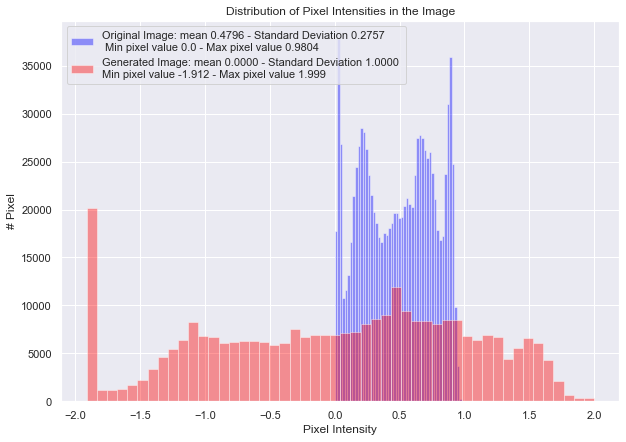

In [19]:
# Include a histogram of the distribution of the pixels
sns.set()
plt.figure(figsize=(10, 7))

# Plot histogram for original iamge
sns.distplot(raw_image.ravel(), 
             label=f'Original Image: mean {np.mean(raw_image):.4f} - Standard Deviation {np.std(raw_image):.4f} \n '
             f'Min pixel value {np.min(raw_image):.4} - Max pixel value {np.max(raw_image):.4}',
             color='blue', 
             kde=False)

# Plot histogram for generated image
sns.distplot(generated_image[0].ravel(), 
             label=f'Generated Image: mean {np.mean(generated_image[0]):.4f} - Standard Deviation {np.std(generated_image[0]):.4f} \n'
             f'Min pixel value {np.min(generated_image[0]):.4} - Max pixel value {np.max(generated_image[0]):.4}', 
             color='red', 
             kde=False)

# Place legends
plt.legend()
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixel')
plt.show()

### Addressing Class Imbalance - Weighted Loss
One of the challenges with working with medical diagnostic datasets is the large class imbalance present in such datasets. Let's plot the frequency of each of the labels in our dataset:

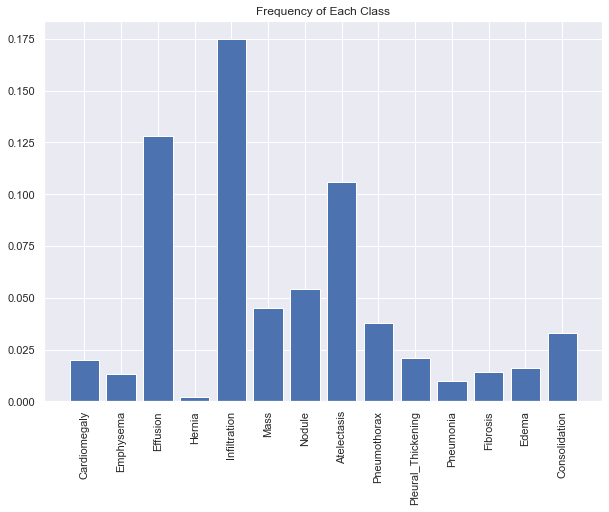

In [20]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

We can see from this plot that the prevalance of positive cases varies significantly across the different pathologies. (These trends mirror the ones in the full dataset as well.) 
* The `Hernia` pathology has the greatest imbalance with the proportion of positive training cases being about 0.2%. 
* But even the `Infiltration` pathology, which has the least amount of imbalance, has only 17.5% of the training cases labelled positive.

Ideally, we would train our model using an evenly balanced dataset so that the positive and negative training cases would contribute equally to the loss. 

#### Impact of class imbalance on loss function

Let's take a closer look at this. Assume we would have used a normal cross-entropy loss for each pathology. We recall that the cross-entropy loss contribution from the $i^{th}$ training data case is:

$$\mathcal{L}_{cross-entropy}(x_i) = -(y_i \log(f(x_i)) + (1-y_i) \log(1-f(x_i))),$$

where $x_i$ and $y_i$ are the input features and the label, and $f(x_i)$ is the output of the model, i.e. the probability that it is positive. 

Note that for any training case, either $y_i=0$ or else $(1-y_i)=0$, so only one of these terms contributes to the loss (the other term is multiplied by zero, and becomes zero). 

We can rewrite the overall average cross-entropy loss over the entire training set $\mathcal{D}$ of size $N$ as follows: 

$$\mathcal{L}_{cross-entropy}(\mathcal{D}) = - \frac{1}{N}\big( \sum_{\text{positive examples}} \log (f(x_i)) + \sum_{\text{negative examples}} \log(1-f(x_i)) \big).$$

Using this formulation, we can see that if there is a large imbalance with very few positive training cases, for example, then the loss will be dominated by the negative class. Summing the contribution over all the training cases for each class (i.e. pathological condition), we see that the contribution of each class (i.e. positive or negative) is: 

$$freq_{p} = \frac{\text{number of positive examples}}{N} $$

$$\text{and}$$

$$freq_{n} = \frac{\text{number of negative examples}}{N}.$$

### Computing Class Frequencies

In [21]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # total number of patients (rows)
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels, axis=0)/N
    negative_frequencies = (N - np.sum(labels, axis=0))/N  # broadcasting of N to a line vector of dim num_classes

    ### END CODE HERE ###
    return positive_frequencies, negative_frequencies

In [22]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.02 , 0.013, 0.128, 0.002, 0.175, 0.045, 0.054, 0.106, 0.038,
       0.021, 0.01 , 0.014, 0.016, 0.033])

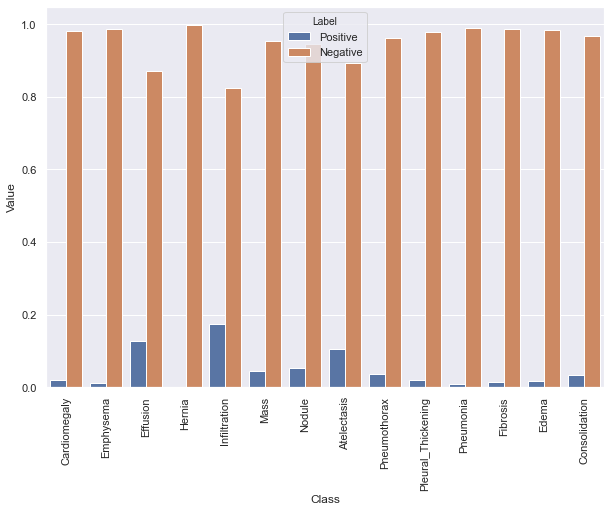

In [23]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

The contributions of positive cases is significantly lower than that of the negative ones. However, we want the contributions to be equal. One way of doing this is by multiplying each example from each class by a class-specific weight factor, $w_{pos}$ and $w_{neg}$, so that the overall contribution of each class is the same. 

To have this, we want 

$$w_{pos} \times freq_{p} = w_{neg} \times freq_{n},$$

which we can do simply by taking 

$$w_{pos} = freq_{neg}$$
$$w_{neg} = freq_{pos}$$

This way, we will be balancing the contribution of positive and negative labels.

In [24]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

Let's verify this by graphing the two contributions next to each other :

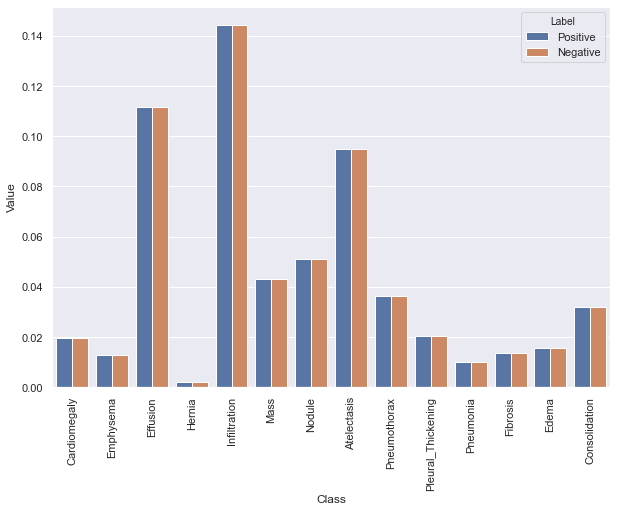

In [25]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

After computing the weights, our final weighted loss for each training case will be 

$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

### Weighted Loss

In [26]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0
        
        ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss += - pos_weights[i] * K.mean(y_true[:,i] * K.log(y_pred[:,i] + epsilon)) \
            - neg_weights[i] * K.mean((1-y_true[:,i]) * K.log(1-y_pred[:,i] + epsilon)) #complete this line
        return loss
    
        ### END CODE HERE ###
    return weighted_loss             # this is a function taking 2 arguments y_true and y_pred

### DenseNet121
Use a pre-trained [DenseNet121](https://www.kaggle.com/pytorch/densenet121) model.Densenet is a convolutional network where each layer is connected to all other layers that are deeper in the network
- The first layer is connected to the 2nd, 3rd, 4th etc.
- The second layer is connected to the 3rd, 4th, 5th etc.
- For a detailed explanation of Densenet, check out the source of the image above, a paper by Gao Huang et al. 2018 called [Densely Connected Convolutional Networks](https://arxiv.org/pdf/1608.06993.pdf).
<img src="densenet.png" alt="U-net Image" width="400" align="middle"/>

we can load directly from Keras and then add two layers on top of it:
1. A `GlobalAveragePooling2D` layer to get the average of the last convolution layers from DenseNet121.
2. A `Dense` layer with `sigmoid` activation to get the prediction logits for each of our classes.

In [42]:
import keras
from keras.applications.densenet import DenseNet121
from keras.models import Model
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras.preprocessing import image

def load_C3M3_model():
   
    class_pos = train_df.loc[:, labels].sum(axis=0)
    class_neg = len(train_df) - class_pos
    class_total = class_pos + class_neg

    pos_weights = class_pos / class_total
    neg_weights = class_neg / class_total
    print("Got loss weights")
    # create the base pre-trained model
    base_model = DenseNet121(weights='densenet.hdf5', include_top=False)
    print("Loaded DenseNet")
    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # and a logistic layer
    predictions = Dense(len(labels), activation="sigmoid")(x)
    print("Added layers")

    model = Model(inputs=base_model.input, outputs=predictions)
    
    model.compile(optimizer='adam', loss=get_weighted_loss(neg_weights, pos_weights))
    print("Compiled Model")

    model.load_weights("nih_new/pretrained_model.h5")
    print("Loaded Weights")
    return model

In [29]:
model = load_C3M3_model()

Got loss weights
Loaded DenseNet
Added layers
Compiled Model
Loaded Weights


let's see the layers that our model is composed of.

In [30]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [33]:
# Print out the total number of layers
layers_ = model.layers
print('total number of layers =',len(layers_))

total number of layers = 429


In [34]:
# The find() method returns an integer value:
# If substring doesn't exist inside the string, it returns -1, otherwise returns first occurence index
conv2D_layers = [layer for layer in model.layers 
                if str(type(layer)).find('Conv2D') > -1]

In [35]:
print('Model input -------------->', model.input)
print('Feature extractor output ->', model.get_layer('conv5_block16_concat').output)
print('Model output ------------->', model.output)

Model input --------------> Tensor("input_2:0", shape=(?, ?, ?, 3), dtype=float32)
Feature extractor output -> Tensor("conv5_block16_concat_1/concat:0", shape=(?, ?, ?, 1024), dtype=float32)
Model output -------------> Tensor("dense_2/Sigmoid:0", shape=(?, 14), dtype=float32)


## Training

In [86]:
history = model.fit_generator(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=100, 
                              validation_steps=25, 
                              epochs = 1)

plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()


Epoch 1/3
  8/100 [=>............................] - ETA: 14:27 - loss: 0.6813

KeyboardInterrupt: 

## Prediction and Evaluation
Now that we have a model, let's evaluate it using our test set. We can conveniently use the predict_generator function to generate the predictions for the images in our test set.

In [37]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))
predicted_vals.shape  # number of test samples x number of classes to predict

(420, 14)

### ROC Curve and AUROC
Compute metric called the AUC (Area Under the Curve) from the ROC ([Receiver Operating Characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)) curve. ideally we want a curve that is more to the left so that the top has more "area" under it, which indicates that the model is performing better.

In [68]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.savefig('ROC.png')
    plt.show()
    return auc_roc_vals

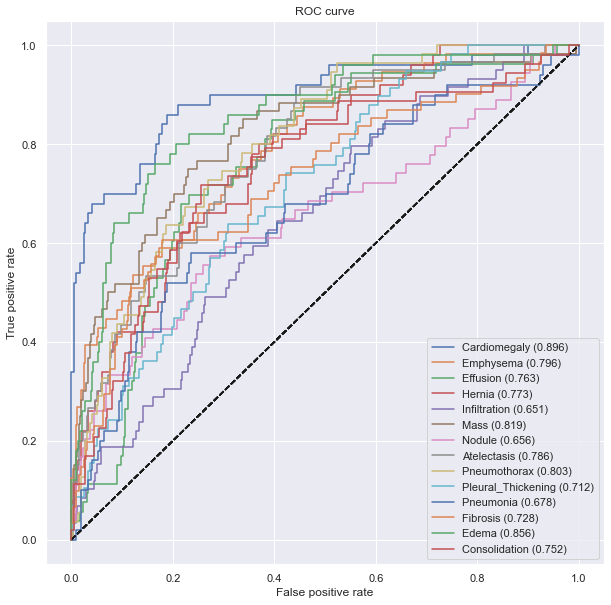

In [69]:
auc_rocs = get_roc_curve(labels, predicted_vals, test_generator)

In [40]:
print("areas under the curve : {} \n for all {} classes".format(auc_rocs,len(auc_rocs)))

areas under the curve : [0.8960540540540539, 0.7963598901098901, 0.7626343118605727, 0.7731351351351351, 0.650828677402695, 0.8193055555555555, 0.6556871078729002, 0.785787037037037, 0.802640099626401, 0.7123737854829492, 0.678, 0.7279327823188274, 0.8563243243243243, 0.7516837180607682] 
 for all 14 classes


## Interpreting Deep Learning Models

Let's load in an X-ray image.

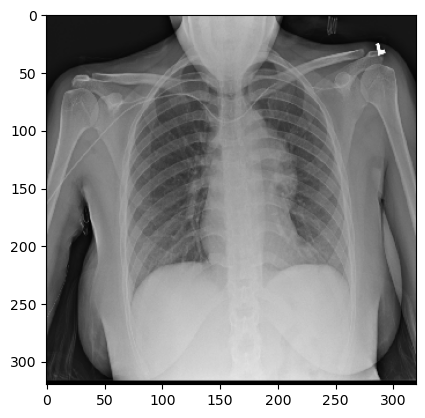

In [71]:
sns.reset_defaults()

def get_mean_std_per_batch(df, H=320, W=320):
    sample_data = []
    for idx, img in enumerate(df.sample(100)["Image"].values):
        path = IMAGE_DIR + img
        sample_data.append(np.array(image.load_img(path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std    

def load_image_normalize(path, mean, std, H=320, W=320):
    x = image.load_img(path, target_size=(H, W))
    x -= mean
    x /= std
    x = np.expand_dims(x, axis=0)
    return x

def load_image(path, df, preprocess=True, H = 320, W = 320):
    """Load and preprocess image."""
    x = image.load_img(path, target_size=(H, W))
    if preprocess:
        mean, std = get_mean_std_per_batch(df, H=H, W=W)
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x

im_path = IMAGE_DIR + '00025288_001.png' 
x = load_image(im_path, train_df, preprocess=False)
plt.imshow(x, cmap = 'gray')
plt.show()

Next, let's get our predictions. Before we plug the image into our model, we have to normalize it. Run the next cell to compute the mean and standard deviation of the images in our training set. 

In [44]:
mean, std = get_mean_std_per_batch(train_df)

Now we are ready to normalize and run the image through our model to get predictions.

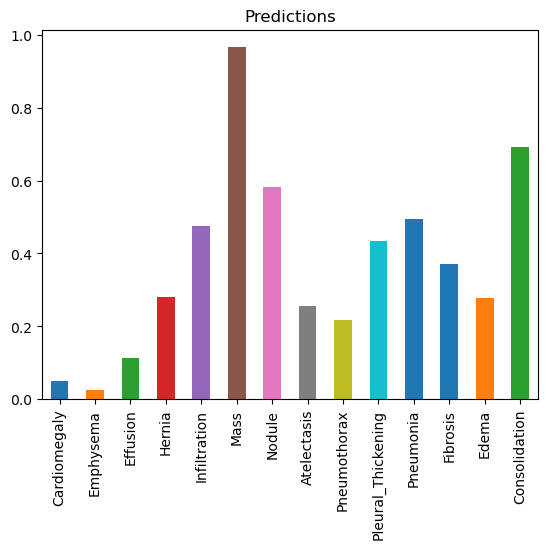

In [72]:
labels = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis',
              'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']

processed_image = load_image_normalize(im_path, mean, std)
preds = model.predict(processed_image)
pred_df = pd.DataFrame(preds, columns = labels)
pred_df.loc[0, :].plot.bar()
plt.title("Predictions")
plt.savefig('predictions.png')
plt.show()

In [46]:
pred_df

,Cardiomegaly,Emphysema,Effusion,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
0,0.049361,0.025269,0.113772,0.280401,0.475629,0.96631,0.582365,0.256831,0.216697,0.433484,0.494812,0.37037,0.279044,0.690861


We see, for example, that the model predicts Mass (abnormal spot or area in the lungs that are more than 3 centimeters) with high probability. Indeed, this patient was diagnosed with mass. However, we don't know where the model is looking when it's making its own diagnosis. To gain more insight into what the model is looking at, we can use GradCAMs.

# GradCAM

GradCAM is a technique to visualize the impact of each region of an image on a specific output for a Convolutional Neural Network model. Through GradCAM, we can generate a heatmap by computing gradients of the specific class scores we are interested in visualizing.

#### Getting Intermediate Layers

Perhaps the most complicated part of computing GradCAM is accessing intermediate activations in our deep learning model and computing gradients with respect to the class output. Typically we'll only be extracting one of the last few. The last few layers usually have more abstract information. To access a layer, we can use `model.get_layer(layer).output`, which takes in the name of the layer in question. Here we are going to extract the raw output of the last convolutional layer `conv5_block16_concat`.

In [47]:
spatial_maps =  model.get_layer('conv5_block16_concat').output
print(spatial_maps)

Tensor("conv5_block16_concat_1/concat:0", shape=(?, ?, ?, 1024), dtype=float32)


Now, this tensor is just a placeholder, it doesn't contain the actual activations for a particular image. To get this we will use [Keras.backend.function](https://www.tensorflow.org/api_docs/python/tf/keras/backend/function) to return intermediate computations while the model is processing a particular input. This method takes in an input and output placeholders and returns a function. This function will compute the intermediate output (until it reaches the given placeholder) evaluated given the input. For example, if you want the layer that you just retrieved (conv5_block16_concat), you could write the following:

In [48]:
get_spatial_maps = K.function([model.input], [spatial_maps])
print(get_spatial_maps)

We see that we now have a `Function` object. Now, to get the actual intermediate output evaluated with a particular input, we just plug in an image to this function:

In [49]:
# get an image
x = load_image_normalize(im_path, mean, std)
print(f"x is of type {type(x)}")
print(f"x is of shape {x.shape}")

x is of type <class 'numpy.ndarray'>
x is of shape (1, 320, 320, 3)


In [50]:
# get the 0th item in the list
spatial_maps_x = get_spatial_maps([x])[0]
print(f"spatial_maps_x is of type {type(spatial_maps_x)}")
print(f"spatial_maps_x is of shape {spatial_maps_x.shape}")
print(f"spatial_maps_x without the batch dimension has shape {spatial_maps_x[0].shape}")

spatial_maps_x is of type <class 'numpy.ndarray'>
spatial_maps_x is of shape (1, 10, 10, 1024)
spatial_maps_x without the batch dimension has shape (10, 10, 1024)


We now have the activations for that particular image, and we can use it for interpretation. The function that is returned by calling `K.function([model.input], [spatial_maps])` (saved here in the variable `get_spatial_maps`) is sometimes referred to as a "hook", letting you peek into the intermediate computations in the model. 

#### Getting Gradients

The other major step in computing GradCAMs is getting gradients with respect to the output for a particular class.

In [51]:
# get the output of the model
output_with_batch_dim = model.output
print(f"Model output includes batch dimension, has shape {output_with_batch_dim.shape}")
print(f"excluding the batch dimension, the output for all 14 categories of disease has shape {output_with_batch_dim[0].shape}")

Model output includes batch dimension, has shape (?, 14)
excluding the batch dimension, the output for all 14 categories of disease has shape (14,)


The output has 14 categories, one for each disease category, indexed from 0 to 13. Cardiomegaly is the disease category at index 0.

In [52]:
# Get the first category's output (Cardiomegaly) at index 0
y_category_0 = output_with_batch_dim[0][0]
print(f"The Cardiomegaly output is at index 0, and has shape {y_category_0.shape}")

The Cardiomegaly output is at index 0, and has shape ()


In [53]:
# Get gradient of y_category_0 with respect to spatial_maps
# The first parameter is the value you are taking the gradient of, and the second is the parameter you are taking that gradient with respect to.
gradient_l = K.gradients(y_category_0, spatial_maps)
print(f"gradient_l is of type {type(gradient_l)} and has length {len(gradient_l)}")

# gradient_l is a list of size 1.  Get the gradient at index 0
gradient = gradient_l[0]
print(gradient)

gradient_l is of type <class 'list'> and has length 1
Tensor("gradients/AddN:0", shape=(?, ?, ?, 1024), dtype=float32)


Again, this is just a placeholder. Just like for intermediate layers, we can use `K.function` to compute the value of the gradient for a particular input.  

The K.function() takes in
- a list of inputs: in this case, one input, 'model.input'
- a list of tensors: in this case, one output tensor 'gradient'

It returns a function that calculates the activations of the list of tensors.
- This returned function returns a list of the activations, one for each tensor that was passed into K.function().

In [54]:
# Create the function that gets the gradient
get_gradient = K.function([model.input], [gradient])
type(get_gradient)

tensorflow.python.keras.backend.GraphExecutionFunction

In [55]:
# get an input x-ray image
x = load_image_normalize(im_path, mean, std)
print(f"X-ray image has shape {x.shape}")

X-ray image has shape (1, 320, 320, 3)


The `get_gradient` function takes in a list of inputs, and returns a list of the gradients, one for each image.

In [56]:
# use the get_gradient function to get the gradient (pass in the input image inside a list)
grad_x_l = get_gradient([x])
print(f"grad_x_l is of type {type(grad_x_l)} and length {len(grad_x_l)}")

# get the gradient at index 0 of the list.
grad_x_with_batch_dim = grad_x_l[0]
print(f"grad_x_with_batch_dim is type {type(grad_x_with_batch_dim)} and shape {grad_x_with_batch_dim.shape}")

# To remove the batch dimension, take the value at index 0 of the batch dimension
grad_x = grad_x_with_batch_dim[0]
print(f"grad_x is type {type(grad_x)} and shape {grad_x.shape}")

grad_x_l is of type <class 'list'> and length 1
grad_x_with_batch_dim is type <class 'numpy.ndarray'> and shape (1, 10, 10, 1024)
grad_x is type <class 'numpy.ndarray'> and shape (10, 10, 1024)


### Implementing GradCAM

In [57]:
def grad_cam(input_model, image, category_index, layer_name):
    """
    GradCAM method for visualizing input saliency.
    
    Args:
        input_model (Keras.model): model to compute cam for
        image (tensor): input to model, shape (1, H, W, 3)
        cls (int): class to compute cam with respect to
        layer_name (str): relevant layer in model
        H (int): input height
        W (int): input width
    Return:
        cam ()
    """
    cam = None
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    # 1. Get placeholders for class output and last layer
    # Get the model's output
    output_with_batch_dim = input_model.output
    
    # Remove the batch dimension
    output_all_categories = output_with_batch_dim[0]
    
    # Retrieve only the disease category at the given category index
    y_c = output_all_categories[category_index]
    
    # Get the input model's layer specified by layer_name, and retrive the layer's output tensor
    spatial_map_layer = input_model.get_layer(layer_name).output

    # 2. Get gradients of last layer with respect to output

    # get the gradients of y_c with respect to the spatial map layer (it's a list of length 1)
    grads_l = K.gradients(y_c, spatial_map_layer)
    
    # Get the gradient at index 0 of the list
    grads = grads_l[0]
        
    # 3. Get hook for the selected layer and its gradient, based on given model's input
    # Hint: Use the variables produced by the previous two lines of code
    spatial_map_and_gradient_function = K.function([input_model.input], [spatial_map_layer, grads])
    
    # Put in the image to calculate the values of the spatial_maps (selected layer) and values of the gradients
    spatial_map_all_dims, grads_val_all_dims = spatial_map_and_gradient_function([image])

    # Reshape activations and gradient to remove the batch dimension
    # Shape goes from (B, H, W, C) to (H, W, C)
    # B: Batch. H: Height. W: Width. C: Channel    
    # Reshape spatial map output to remove the batch dimension
    spatial_map_val = spatial_map_all_dims[0]
    
    # Reshape gradients to remove the batch dimension
    grads_val = grads_val_all_dims[0]
    
    # 4. Compute weights using global average pooling on gradient 
    # grads_val has shape (Height, Width, Channels) (H,W,C)
    # Take the mean across the height and also width, for each channel
    # Make sure weights have shape (C)
    weights = np.mean(grads_val, axis=(0,1))
    
    # 5. Compute dot product of spatial map values with the weights
    cam = np.dot(spatial_map_val, weights)    # shape (10,10,1024) x shape(1024,) resulting into shape(10,10)

    ### END CODE HERE ###
    
    # We'll take care of the postprocessing.
    H, W = image.shape[1], image.shape[2]
    cam = np.maximum(cam, 0) # ReLU so we only get positive importance
    cam = cv2.resize(cam, (W, H), cv2.INTER_NEAREST)
    cam = cam / cam.max()

    return cam

- Generate the CAM for the image

In [59]:
im = load_image_normalize(im_path, mean, std)
cam = grad_cam(model, im, 5, 'conv5_block16_concat') # Mass is class 5

- Visualize the CAM and the original image. 

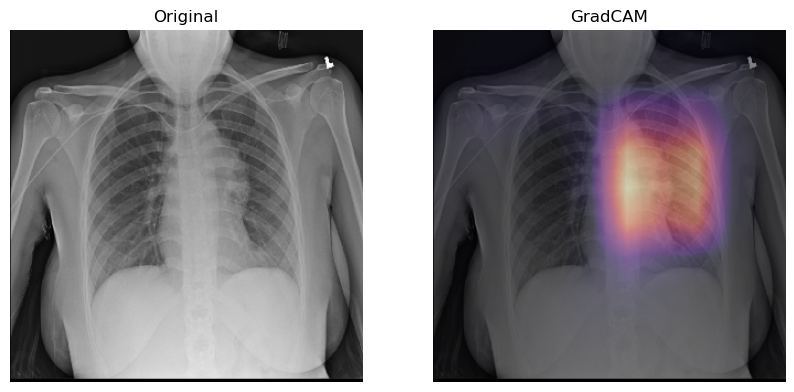

In [60]:
plt.rcParams['figure.figsize'] = [10, 7]
plt.subplot(121)
plt.imshow(load_image(im_path, train_df, preprocess=False), cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(122)
plt.imshow(load_image(im_path, train_df, preprocess=False), cmap='gray')
plt.imshow(cam, cmap='magma', alpha=0.5)
plt.title("GradCAM")
plt.axis('off')
plt.show()

We can see that it focuses on the large (white) empty area on the right lung. Indeed this is a clear case of Mass.


### Using GradCAM to Visualize Multiple Labels

We can use GradCAMs for multiple labels on the same image. Let's do it for the labels with best AUC for our model, Cardiomegaly, Mass, and Edema. 

In [61]:
def compute_gradcam(model, img, mean, std, data_dir, df, 
                    labels, selected_labels, layer_name='conv5_block16_concat'):
    """
    Compute GradCAM for many specified labels for an image. 
    This method will use the `grad_cam` function.
    
    Args:
        model (Keras.model): Model to compute GradCAM for
        img (string): Image name we want to compute GradCAM for.
        mean (float): Mean to normalize to image.
        std (float): Standard deviation to normalize the image.
        data_dir (str): Path of the directory to load the images from.
        df(pd.Dataframe): Dataframe with the image features.
        labels ([str]): All output labels for the model.
        selected_labels ([str]): All output labels we want to compute the GradCAM for.
        layer_name: Intermediate layer from the model we want to compute the GradCAM for.
    """
    img_path = data_dir + img
    preprocessed_input = load_image_normalize(img_path, mean, std)
    predictions = model.predict(preprocessed_input)
    print("Ground Truth: ", ", ".join(np.take(labels, np.nonzero(df[df["Image"] == img][labels].values[0]))[0]))

    plt.figure(figsize=(20, 15))
    plt.subplot(151)
    plt.title("Original")
    plt.axis('off')
    plt.imshow(load_image(img_path, df, preprocess=False), cmap='gray')
    
    j = 1
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###    
    # Loop through all labels
    for i in range(len(labels)): # complete this line
        # Compute CAM and show plots for each selected label.
        
        # Check if the label is one of the selected labels
        if labels[i] in selected_labels: # complete this line
            
            # Use the grad_cam function to calculate gradcam
            gradcam = grad_cam(model, preprocessed_input, i, layer_name)
            
            ### END CODE HERE ###
            
            print("Generating gradcam for class %s (p=%2.2f)" % (labels[i], round(predictions[0][i], 3)))
            plt.subplot(151 + j)
            plt.title(labels[i] + ": " + str(round(predictions[0][i], 3)))
            plt.axis('off')
            plt.imshow(load_image(img_path, df, preprocess=False), cmap='gray')
            plt.imshow(gradcam, cmap='magma', alpha=min(0.5, predictions[0][i]))
            j +=1

Run the following cells to print the ground truth diagnosis for a given case and show the original x-ray as well as GradCAMs for Cardiomegaly, Mass, and Edema.

Ground Truth:  Cardiomegaly
Generating gradcam for class Cardiomegaly (p=0.88)
Generating gradcam for class Mass (p=0.22)
Generating gradcam for class Edema (p=0.06)


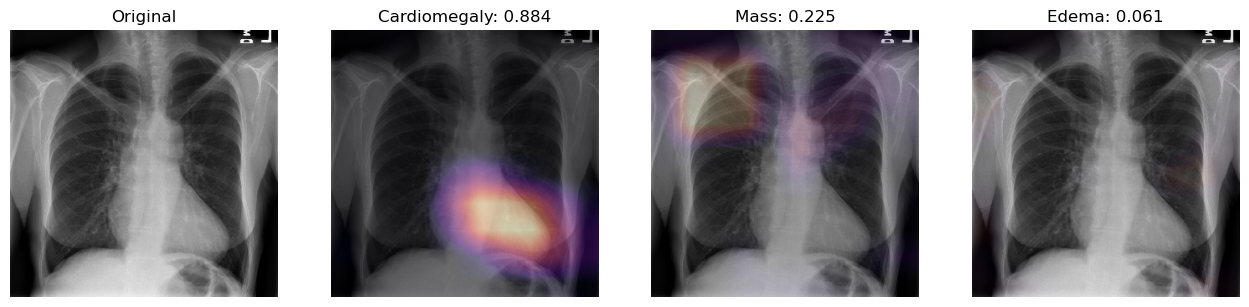

In [62]:
image_filename = '00016650_000.png'
labels_to_show = ['Cardiomegaly', 'Mass', 'Edema']
compute_gradcam(model, image_filename, mean, std, IMAGE_DIR, train_df, labels, labels_to_show)

The model correctly predicts absence of mass or edema. The probability for mass is higher, and we can see that it may be influenced by the shapes in the middle of the chest cavity, as well as around the shoulder.

Ground Truth:  Mass
Generating gradcam for class Cardiomegaly (p=0.01)
Generating gradcam for class Mass (p=0.95)
Generating gradcam for class Edema (p=0.15)


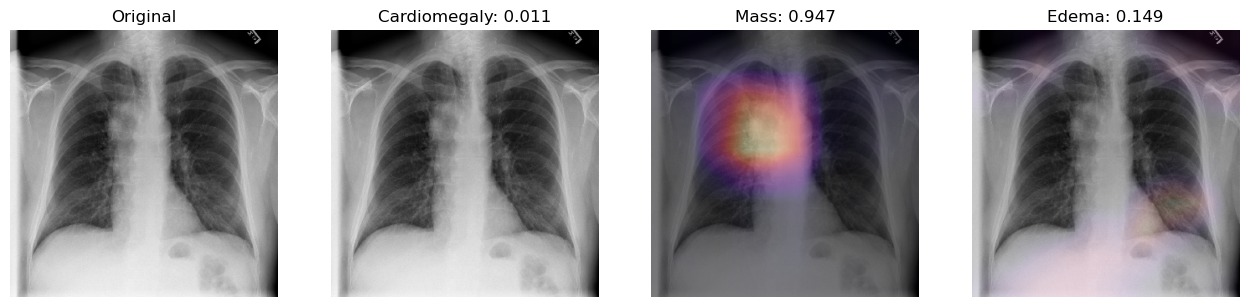

In [214]:
image_filename = '00005410_000.png'
compute_gradcam(model, image_filename, mean, std, IMAGE_DIR, train_df, labels, labels_to_show)

In the example above, the model correctly focuses on the mass near the center of the chest cavity. 

Ground Truth:  Edema
Generating gradcam for class Cardiomegaly (p=0.26)
Generating gradcam for class Mass (p=0.24)
Generating gradcam for class Edema (p=0.86)


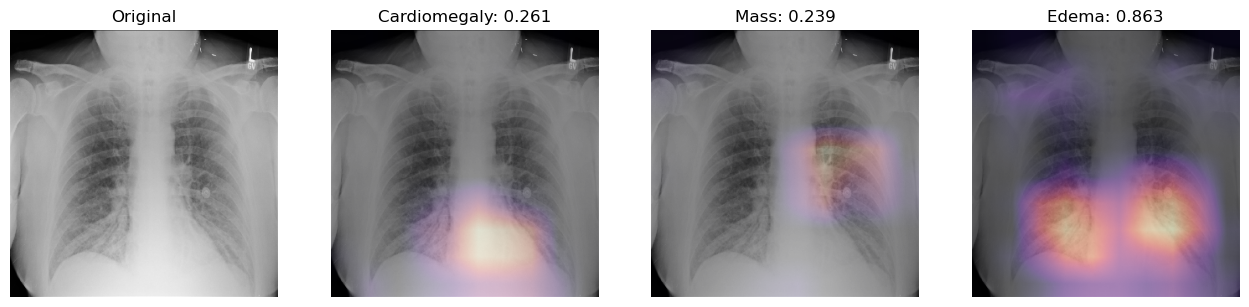

In [212]:
image_name = '00004090_002.png'
compute_gradcam(model, image_name, mean, std, IMAGE_DIR, train_df, labels, labels_to_show)

Here the model correctly picks up the signs of edema near the bottom of the chest cavity. We can also notice that Cardiomegaly has a high score for this image, though the ground truth doesn't include it.
This visualization might be helpful for error analysis; for example, we can notice that the model is indeed looking at the expected area to make the prediction.

Ground Truth:  Mass
Generating gradcam for class Cardiomegaly (p=0.04)
Generating gradcam for class Mass (p=0.97)
Generating gradcam for class Edema (p=0.30)


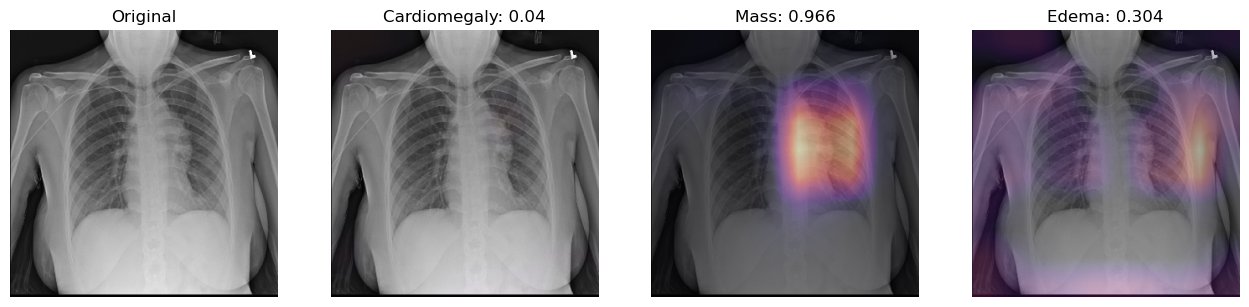

In [215]:
image_name = '00025288_001.png'
compute_gradcam(model, image_name, mean, std, IMAGE_DIR, train_df, labels, labels_to_show)

Here the model picks up signs of the mass near the center of the chest cavity on the right. Edema has a high score for this image, though the ground truth doesn't include it.

## Interpretation tools like this one can be helpful for discovery of markers, error analysis, and even in deployment. 